In [1]:
symbol = 'ETHUSDT'

In [3]:
import pandas as pd

data_4h = pd.read_csv(f'{symbol}_4h.csv')
data_4h['Timestamp'] = pd.to_datetime(data_4h['Timestamp'], unit='ms')
data_4h.set_index('Timestamp',inplace=True)

data_1h = pd.read_csv(f'{symbol}_1h.csv')
data_1h['Timestamp'] = pd.to_datetime(data_1h['Timestamp'], unit='ms')
data_1h.set_index('Timestamp',inplace=True)


In [4]:
# === CALCULATE RSI Divergence ===
def rsi_custom(series, length):
    delta = series.diff()
    up = delta.clip(lower=0)
    down = -delta.clip(upper=0)
    ma_up = up.rolling(length).mean()
    ma_down = down.rolling(length).mean()
    rsi = 100 - (100 / (1 + ma_up / ma_down))
    return rsi

In [5]:
import pandas as pd
import numpy as np

def rsi_divergence(df, len_fast=5, len_slow=14):
    """
    Calculate RSI Divergence between fast and slow RSI
    :param df: pandas DataFrame containing price data
    :param len_fast: length for fast RSI (default 5)
    :param len_slow: length for slow RSI (default 14)
    :return: DataFrame with RSI values and divergence
    """
    
    # Calculate fast RSI
    delta_fast = df['Close'].diff()
    up_fast = delta_fast.clip(lower=0)
    down_fast = -1 * delta_fast.clip(upper=0)
    
    # Calculate EMA for up and down movements
    up_fast_ema = up_fast.ewm(alpha=1/len_fast, adjust=False).mean()
    down_fast_ema = down_fast.ewm(alpha=1/len_fast, adjust=False).mean()
    
    # Calculate RSI
    rs_fast = up_fast_ema / down_fast_ema
    df['rsi_fast'] = 100 - (100 / (1 + rs_fast))
    
    # Calculate slow RSI
    delta_slow = df['Close'].diff()
    up_slow = delta_slow.clip(lower=0)
    down_slow = -1 * delta_slow.clip(upper=0)
    
    # Calculate EMA for up and down movements
    up_slow_ema = up_slow.ewm(alpha=1/len_slow, adjust=False).mean()
    down_slow_ema = down_slow.ewm(alpha=1/len_slow, adjust=False).mean()
    
    # Calculate RSI
    rs_slow = up_slow_ema / down_slow_ema
    df['rsi_slow'] = 100 - (100 / (1 + rs_slow))
    
    # Calculate divergence
    df['divergence'] = df['rsi_fast'] - df['rsi_slow']
    
    return df

# Example usage:
# Assuming you have a DataFrame 'data' with 'close' prices
# data = rsi_divergence(data)
# data['divergence_color'] = np.where(data['divergence'] > 0, 'lime', 'red')

In [6]:
import pandas as pd

fast_len = 5
slow_len = 14

# # Compute RSI and divergence for 4H data
# data_4h['RSI_fast'] = rsi_custom(data_4h['Close'], fast_len)
# data_4h['RSI_slow'] = rsi_custom(data_4h['Close'], slow_len)
# data_4h['divergence'] = data_4h['RSI_fast'] - data_4h['RSI_slow']
# data_4h.dropna(inplace=True)
data_4h = rsi_divergence(data_4h, len_fast=5, len_slow=14)

# Prepare a new divergence column in 1H data
data_1h['divergence'] = None

# Map 4H divergence to each 1H row based on its floored 4H time
from datetime import timedelta

for i in range(len(data_1h)):
    idx = data_1h.index[i]
    dt = pd.Timestamp(idx).floor('4h') - timedelta(hours=4)  # Corrected timedelta syntax
    if dt in data_4h.index:
        data_1h.at[idx, 'divergence'] = data_4h.at[dt, 'divergence']


In [7]:
data_1h.tail(10)

,Open,High,Low,Close,Volume,Close_time,Quote_asset_volume,Number_of_trades,Taker_buy_base,Taker_buy_quote,Ignore,divergence
Timestamp,,,,,,,,,,,,
2025-05-31 15:00:00,2542.51,2550.14,2532.41,2536.30,17674.8096,1748707199999,4.490871e+07,103585,7861.6521,1.997603e+07,0,-18.644524
2025-05-31 16:00:00,2536.29,2547.99,2533.00,2540.59,9951.9464,1748710799999,2.527915e+07,69296,4680.0350,1.188902e+07,0,-5.507031
2025-05-31 17:00:00,2540.59,2541.14,2523.36,2527.39,9812.9656,1748714399999,2.485246e+07,69073,4105.5856,1.040121e+07,0,-5.507031
2025-05-31 18:00:00,2527.38,2542.40,2525.99,2539.73,4328.3413,1748717999999,1.097803e+07,47020,2243.7549,5.690018e+06,0,-5.507031
2025-05-31 19:00:00,2539.74,2543.00,2536.36,2537.40,5070.3815,1748721599999,1.287805e+07,48400,2176.8695,5.529115e+06,0,-5.507031
2025-05-31 20:00:00,2537.39,2542.43,2531.67,2542.19,6281.2963,1748725199999,1.594478e+07,46194,2125.4937,5.395611e+06,0,-4.664963
2025-05-31 21:00:00,2542.20,2550.34,2539.32,2543.21,9431.0987,1748728799999,2.399891e+07,55343,4718.0301,1.200576e+07,0,-4.664963
2025-05-31 22:00:00,2543.21,2545.00,2530.69,2530.76,8477.3580,1748732399999,2.151881e+07,71464,4047.7347,1.027572e+07,0,-4.664963
2025-05-31 23:00:00,2530.76,2548.31,2524.41,2528.06,11928.5708,1748735999999,3.023123e+07,74215,6883.4318,1.744372e+07,0,-4.664963


In [8]:
data_1h = data_1h.dropna()

In [9]:
import matplotlib.pyplot as plt

initial_cash = 1000
dca_amount = 100

cash = initial_cash
holding = 0
portfolio = []

for i in range(len(data_1h)):
    price = data_1h['Close'].iloc[i]
    divergence = data_1h['divergence'].iloc[i]

    # Buy condition
    if divergence > 0 and cash >= dca_amount:
        holding += dca_amount / price
        cash -= dca_amount

    # Sell condition (liquidate all)
    elif divergence < 0 and holding > 0:
        cash += holding * price
        holding = 0

    total_value = cash + holding * price
    portfolio.append(total_value)

# Store the portfolio values
data_1h['portfolio'] = portfolio

In [10]:
len(portfolio),len(data_1h)

(3617, 3617)

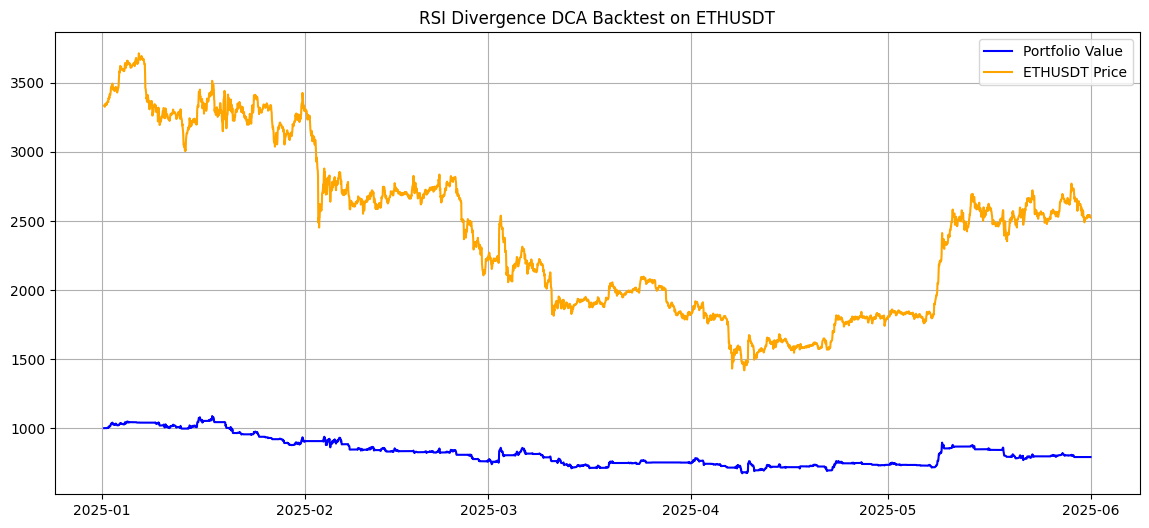

In [11]:
plt.figure(figsize=(14,6))
plt.plot(data_1h['portfolio'], label='Portfolio Value', color='blue')
plt.plot(data_1h['Close'], label=f'{symbol} Price', color='orange')
plt.legend()
plt.title(f"RSI Divergence DCA Backtest on {symbol}")
plt.grid()
plt.show()
